In [14]:
import numpy as np
import skrf
from skrf import Network
from glob import glob
from re import match, search
import re
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.optimize import minimize, shgo

In [15]:
fr = 1.575e9
df = 200e6
def resonant_frequency_bandwidth(f, s11):
    BW_limit = -10
    rng = np.logical_and(f >= fr-df, f <= fr+df)
    s11_clip = s11[rng]
    f_clip = f[rng]

    s11_interp = interp1d(f_clip, s11_clip, kind='cubic')
    f_up = np.linspace(f_clip.min(), f_clip.max(), 5000)
    s11_up = s11_interp(f_up)
    res_index = np.where(s11_up == np.min(s11_up))[0][0]

    bw_index = np.where(s11_interp(f_up) <= BW_limit)[0]
    fres = (f_up[res_index], s11_up[res_index])
    if bw_index.size == 0:
        fmin = None
        fmax = None
    else:
        fmin = (f_up[bw_index[0]], s11_up[bw_index[0]])
        fmax = (f_up[bw_index[-1]], s11_up[bw_index[-1]])




    return f_up, s11_up, fres, fmin, fmax

In [20]:
runs = {}
for filename in glob('../Antenna_Patch/Antenne_Patch_ceramique_*.s1p'):
    print(filename)
    runID = int((search(r"(?:_)([0-9]+)(?:\.s1p)", filename)).group(1))
    
    network = Network(filename)
    s11 = network.s11.s_db.squeeze()
    f = network.s11.f.squeeze()
    runs[runID] = resonant_frequency_bandwidth(f, s11)

../Antenna_Patch\Antenne_Patch_ceramique_1.s1p
../Antenna_Patch\Antenne_Patch_ceramique_10.s1p
../Antenna_Patch\Antenne_Patch_ceramique_2.s1p
../Antenna_Patch\Antenne_Patch_ceramique_3.s1p
../Antenna_Patch\Antenne_Patch_ceramique_4.s1p
../Antenna_Patch\Antenne_Patch_ceramique_5.s1p
../Antenna_Patch\Antenne_Patch_ceramique_6.s1p
../Antenna_Patch\Antenne_Patch_ceramique_7.s1p
../Antenna_Patch\Antenne_Patch_ceramique_8.s1p
../Antenna_Patch\Antenne_Patch_ceramique_9.s1p


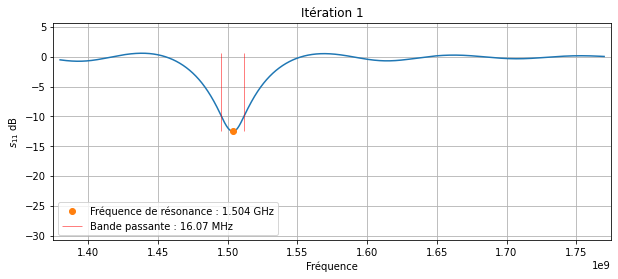

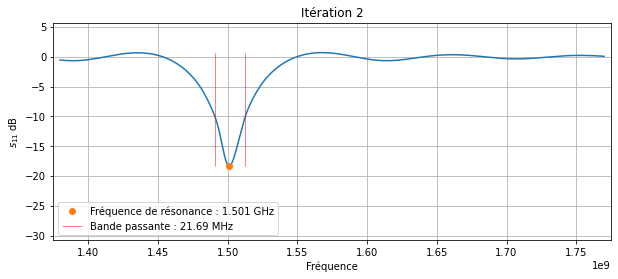

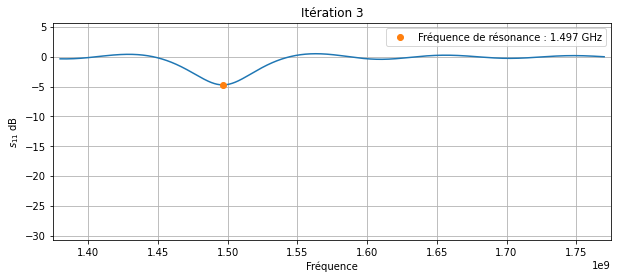

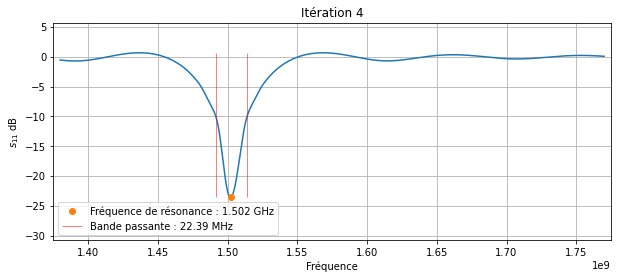

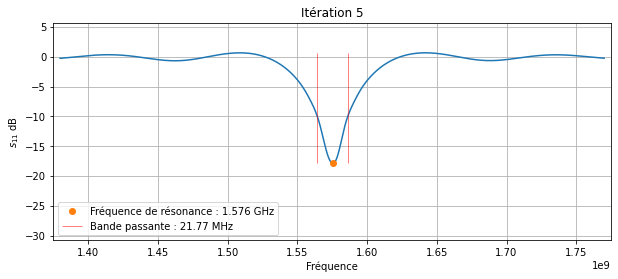

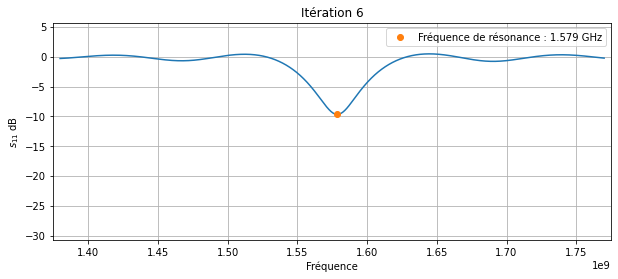

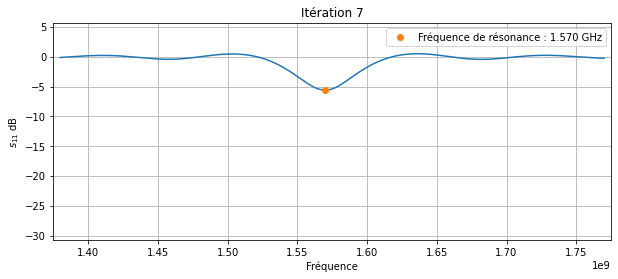

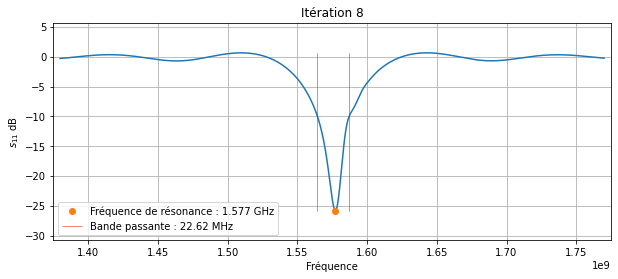

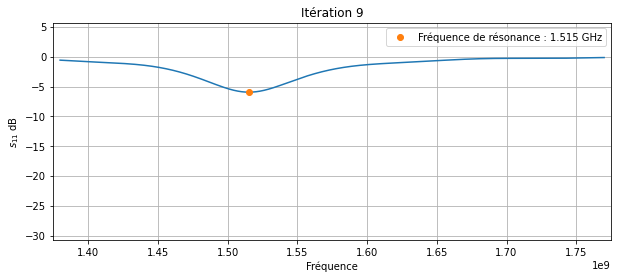

In [17]:
for i in range(1, len(runs)+1):
    r = runs[i]
    f, s11, fres, fmin, fmax = r

    plt.figure(figsize=(10,4))
    plt.ylim([s11_min - 5, s11_max + 5])
    plt.plot(f, s11)
    plt.xlim([fr-df, fr+df])
    plt.plot(*fres, 'o', label=f"Fréquence de résonance : {fres[0]/1e9:.3f} GHz")

    if fmax is not None:
        BW = fmax[0] - fmin[0]
        plt.vlines([fmin[0], fmax[0]], np.min(s11), np.max(s11), linewidth=0.5, colors='r', label=f"Bande passante : {BW/1e6:.2f} MHz")
    
    plt.ylabel('$s_{11}$ dB')
    plt.xlabel('Fréquence') 
    plt.grid()
    plt.legend()
    plt.title(f'Itération {i}')
    plt.savefig(f'run_id_ceramique_{i}.png', dpi=200)

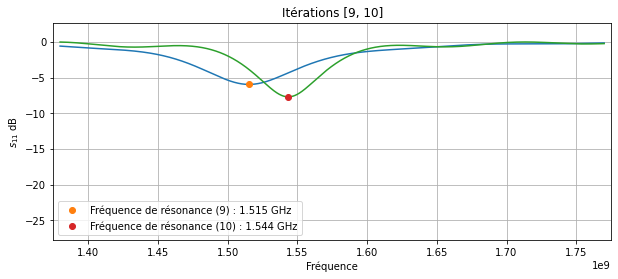

In [21]:
s11_min = np.min([r[1] for r in runs.values()])
s11_max = np.max([r[1] for r in runs.values()])

for I in [[9,10]]:
    plt.figure(figsize=(10,4))
    plt.ylim([s11_min - 2, s11_max + 2])
    plt.xlim([fr-df, fr+df])
    for i in I:
        r = runs[i]
        f, s11, fres, fmin, fmax = r

        plt.plot(f, s11)
        
        plt.plot(*fres, 'o', label=f"Fréquence de résonance ({i}) : {fres[0]/1e9:.3f} GHz")

        if fmax is not None:
            BW = fmax[0] - fmin[0]
            plt.vlines([fmin[0], fmax[0]], np.min(s11), np.max(s11), linewidth=0.5, colors='r', label=f"Bande passante ({i}) : {BW/1e6:.2f} MHz")
    
    plt.ylabel('$s_{11}$ dB')
    plt.xlabel('Fréquence')
    plt.grid()
    plt.legend()
    plt.title(f'Itérations {I}')
    plt.savefig(f'run_id_ceramique_{"".join([str(a) for a in I])}.png', dpi=200)